# Housing V3 Project Outline
### 0. Problem Definition  
### 1. Import Libraries
### 2. Data Import  
### 3. Data Exploration (EDA)  
### 4. Data Cleaning & Preprocessing  
### 5. Modeling  
### 6. Evaluation  
### 7. Deployment 

## 0. Problem Definion
- Goal: Predict house prices based on various features.

- Type: Supervised regression problem.

- Metric: RMSE / MAE / R².



## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch core
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

# Scikit-learn tools for preprocessing and splitting
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Additional libraries
import copy
import joblib  

# Random seed for reproducibility
import random
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## 2. Data Import

In [2]:
# Define paths for the dataset
data_train_path = "/Users/kevingoldberg/Documents/Personal Projects/Housing/house-prices-advanced-regression-techniques/train.csv"
data_test_path = "/Users/kevingoldberg/Documents/Personal Projects/Housing/house-prices-advanced-regression-techniques/test.csv"

# Load the dataset
df_train = pd.read_csv(data_train_path)
df_test = pd.read_csv(data_test_path)

# Preview the Data
print("Training Data Preview:")
print(df_train.head())
print("\nTest Data Preview:")
print(df_test.head())

Training Data Preview:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice 

## 3. EDA

### 3.1 Explore Data Structure

In [3]:
# Display the shape of the datasets
print("\nTraining Data Shape:", df_train.shape)

# Data types and missing values
print("\nTraining Data Types and Missing Values:")
print(df_train.info())

# Summary statistics
print("\nTraining Data Summary Statistics:")
print(df_train.describe())



Training Data Shape: (1460, 81)

Training Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 no

### 3.2 Understand Feature Types

In [4]:
# Drop Target Variable and ID from Features
df_train_features = df_train.drop(columns=['Id', 'SalePrice'])
df_train_target = df_train['SalePrice']

# Seperate Features by Data Type
numeric_features = df_train_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_train_features.select_dtypes(include=['object']).columns.tolist()
bool_features = df_train_features.select_dtypes(include=['bool']).columns.tolist()

# Print the number of features in each category
print("\nNumber of Numeric Features:", len(numeric_features))
print("Number of Categorical Features:", len(categorical_features))
print("Number of Boolean Features:", len(bool_features))

# Number of Unique Values per Feature
print("\nNumber of Unique Values per Numerical Feature:")
print(df_train_features[numeric_features].nunique().sort_values(ascending=False).head())
print("\nNumber of Unique Values per Categorical Feature:")
print(df_train_features[categorical_features].nunique().sort_values(ascending=False).head())


Number of Numeric Features: 36
Number of Categorical Features: 43
Number of Boolean Features: 0

Number of Unique Values per Numerical Feature:
LotArea        1073
GrLivArea       861
BsmtUnfSF       780
1stFlrSF        753
TotalBsmtSF     721
dtype: int64

Number of Unique Values per Categorical Feature:
Neighborhood    25
Exterior2nd     16
Exterior1st     15
SaleType         9
Condition1       9
dtype: int64


### 3.3 Missing Values


Missing values per column:
LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64


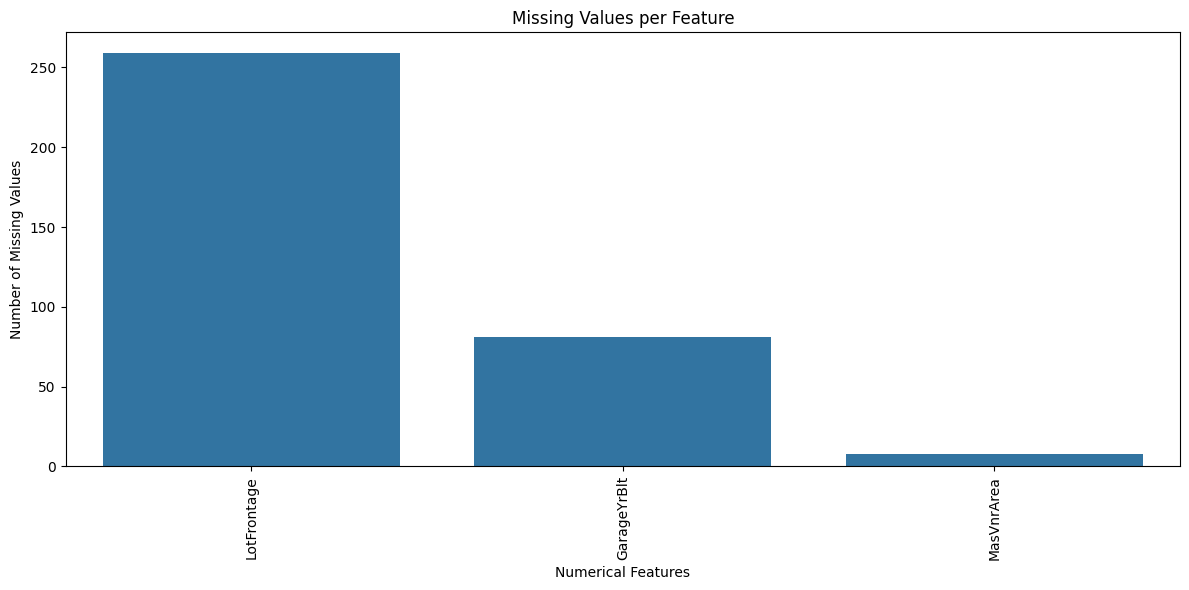


Missing values per categorical column:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
Electrical         1
dtype: int64


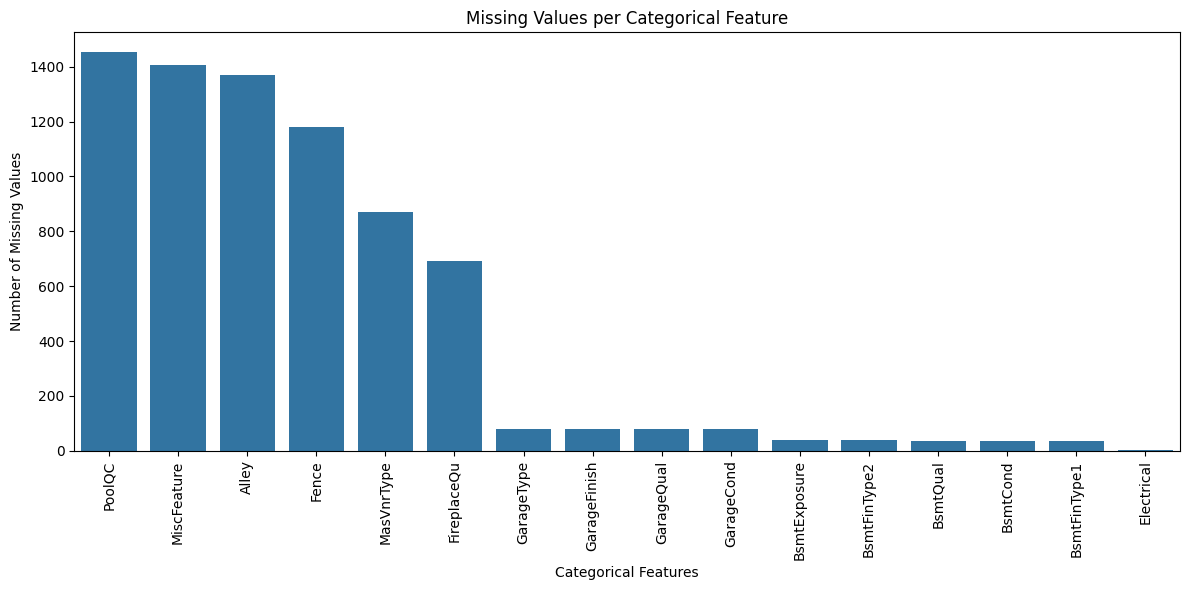

In [5]:
# Count missing values per numerical column (descending)
missing_numeric = df_train_features[numeric_features].isnull().sum()
missing_numeric = missing_numeric[missing_numeric > 0].sort_values(ascending=False)
print("\nMissing values per column:")
print(missing_numeric)
# Visualize missing numerical values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_numeric.index, y=missing_numeric.values)
plt.xticks(rotation=90)
plt.title('Missing Values per Feature')
plt.xlabel('Numerical Features')
plt.ylabel('Number of Missing Values')
plt.tight_layout()
plt.show()

# Count missing values per categorical column (descending)
missing_categorical = df_train_features[categorical_features].isnull().sum()
missing_categorical = missing_categorical[missing_categorical > 0].sort_values(ascending=False)
print("\nMissing values per categorical column:")
print(missing_categorical)
# Visualize missing categorical values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_categorical.index, y=missing_categorical.values)
plt.xticks(rotation=90)
plt.title('Missing Values per Categorical Feature')
plt.xlabel('Categorical Features')
plt.ylabel('Number of Missing Values')
plt.tight_layout()
plt.show()

### 3.4 Target Variable Analysis


Basic Statistics for Target Feature (SalePrice):
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness of SalePrice: 1.8828757597682129
Kurtosis of SalePrice: 6.536281860064529


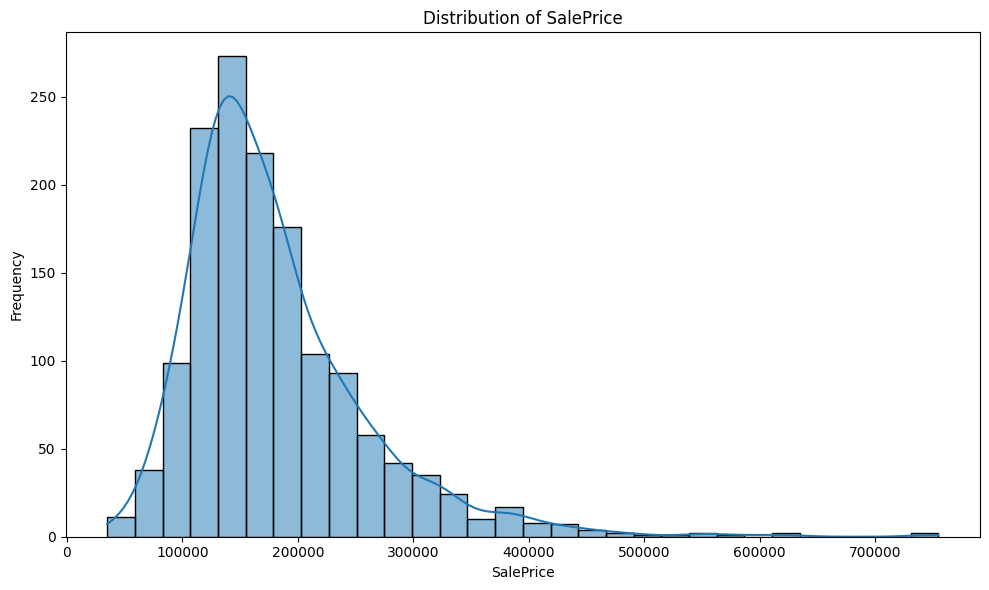

In [6]:
# Basic Statistics for Target Features
print("\nBasic Statistics for Target Feature (SalePrice):")
print(df_train_target.describe())

# Skewness and Kurtosis
print("\nSkewness of SalePrice:", df_train_target.skew())
print("Kurtosis of SalePrice:", df_train_target.kurtosis())

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df_train_target, kde=True, bins=30)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 3.5 Cateogircal Feature Relationships


Top 10 Features Positively Correlated with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Top 10 Features Negatively Correlated with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


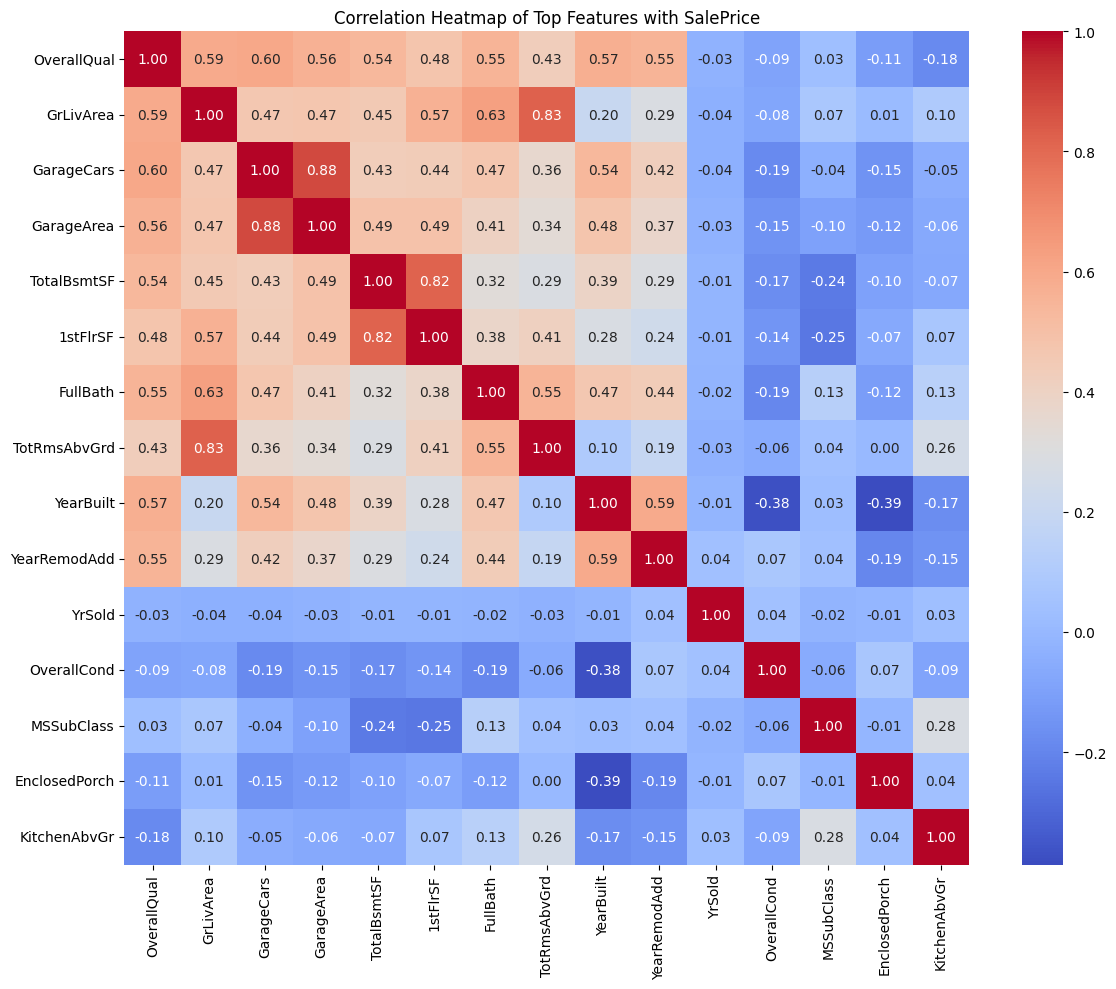

In [7]:
# Compute correlation with target
correlations = df_train[numeric_features + ['SalePrice']].corr()

# Sort by correlation with SalePrice
top_corr = correlations['SalePrice'].drop('SalePrice').sort_values(ascending=False)

print("\nTop 10 Features Positively Correlated with SalePrice:")
print(top_corr.head(10))

print("\nTop 10 Features Negatively Correlated with SalePrice:")
print(top_corr.tail(5))

# Combine top correlated features
top_features = top_corr.index.tolist()[:10] + top_corr.index.tolist()[-5:]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlations.loc[top_features, top_features], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top Features with SalePrice')
plt.tight_layout()
plt.show()


### 3.6 Categorical Feature Relationships

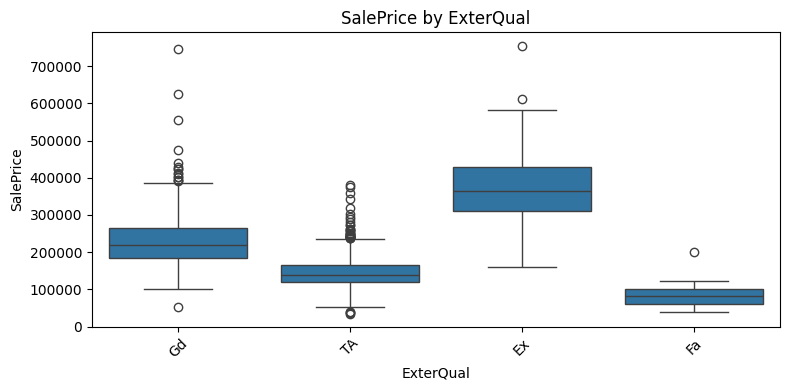

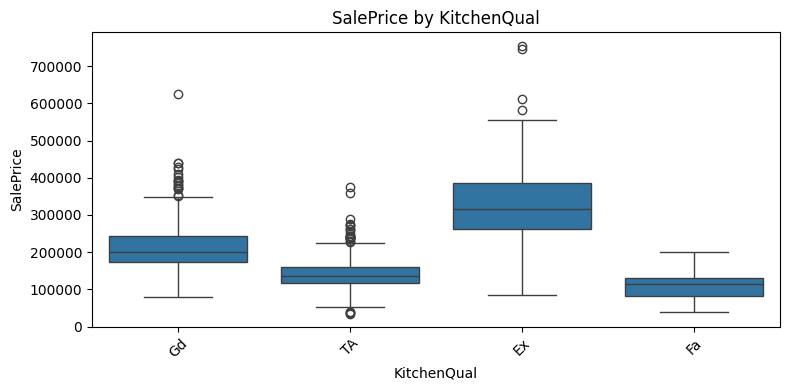

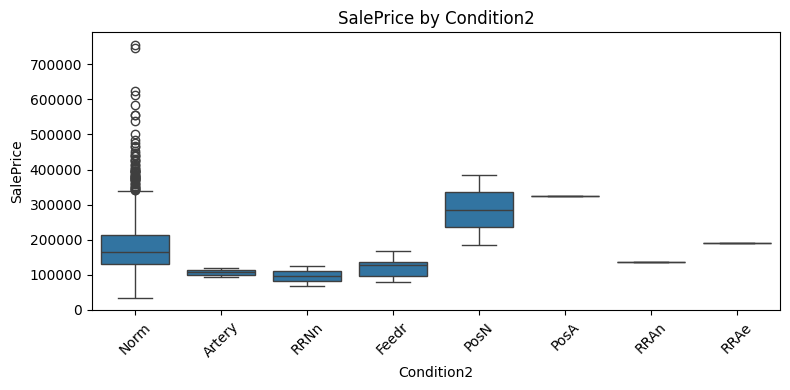

In [8]:
### 3.6 Categorical Feature Relationships

# Select categorical features with relatively few categories
cat_counts = df_train[categorical_features].nunique().sort_values()
few_unique = cat_counts[cat_counts <= 15].index.tolist()

# Choose top 3 based on correlation with SalePrice (via mean encoding)
cat_corr = {}

for col in few_unique:
    if df_train[col].isnull().any():
        continue  # skip if missing values
    cat_corr[col] = df_train.groupby(col)['SalePrice'].mean().std()  # higher std => better separability

# Sort and pick top 3
top_cat_features = sorted(cat_corr, key=cat_corr.get, reverse=True)[:3]

# Boxplots for top categorical features
for col in top_cat_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_train[col], y=df_train['SalePrice'])
    plt.title(f'SalePrice by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 4. Data Cleaning and Preprocessing

### 4.1 Handle Missing Values

In [9]:
# Drop ID and SalePrice from training features
df_train_features = df_train.drop(columns = ['Id','SalePrice'])
df_test_features = df_test.drop(columns=['Id'])

# Handle Missing Numerical Values
num_means = df_train_features[numeric_features].mean()

df_train_features[numeric_features] = df_train_features[numeric_features].fillna(num_means)
df_test_features[numeric_features]  = df_test_features[numeric_features].fillna(num_means)

# Handle Missing Categorical Values
df_train_features[categorical_features] = df_train_features[categorical_features].fillna('Missing')
df_test_features[categorical_features] = df_test_features[categorical_features].fillna('Missing')

# Print the number of missing values after imputation
print("Missing training values after imputation:", df_train_features.isnull().sum().sum())
print("Missing test values after imputation:", df_test_features.isnull().sum().sum())


Missing training values after imputation: 0
Missing test values after imputation: 0


### 4.2 Encode Categorical Variables

In [10]:
# Combine Train and Test Features for Encoding
X_combined = pd.concat([df_train_features, df_test_features], axis=0)

# Encode Categorical Features using One-Hot Encoding
X_combined_encoded = pd.get_dummies(X_combined, columns=categorical_features, drop_first=True)

# Split back into train and test sets
X_train_encoded = X_combined_encoded.iloc[:df_train_features.shape[0], :].copy()
X_test_encoded = X_combined_encoded.iloc[df_train_features.shape[0]:, :].copy()

print("Encoded Training Features Shape:", X_train_encoded.shape)
print("Encoded Test Features Shape:", X_test_encoded.shape)

Encoded Training Features Shape: (1460, 267)
Encoded Test Features Shape: (1459, 267)


### 4.3 Align Train/Test Columns

In [11]:
# Ensure test has the same columns as train
X_test_aligned = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Confirm alignment
assert X_train_encoded.shape[1] == X_test_aligned.shape[1], "Train/Test column mismatch!"
print("Train and Test feature sets successfully aligned.")

Train and Test feature sets successfully aligned.


### 4.4 Feature Scaling

In [12]:
# Memory Optimization
X_train_encoded = X_train_encoded.astype(np.float32)
X_test_encoded  = X_test_encoded.astype(np.float32)

# Initialize Standard Scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_aligned)

# Save scaler to disk
joblib.dump(scaler, "std_scaler.pkl")

['std_scaler.pkl']

### 4.5 Convert to PyTorch Tensors

In [13]:
# Convert scaled features to tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(X_test_scaled,  dtype=torch.float32).to(device)

# Convert log-transformed target to tensor and move to device
y_train_array  = np.log1p(df_train['SalePrice'].values).reshape(-1, 1)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)


## 5. Modeling

### 5.1 Define the Neural Network 

In [14]:
class HousingPriceModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # output: log-price
        )

    def forward(self, x):
        return self.net(x)

# Instantiate and move to device
input_size = X_train_tensor.shape[1]
model = HousingPriceModel(input_size).to(device)
print(model)

HousingPriceModel(
  (net): Sequential(
    (0): Linear(in_features=267, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


### 5.2 Train/Validation Split

In [15]:
# Combine features and target into one dataset
full_ds = TensorDataset(X_train_tensor, y_train_tensor)

# Define validation ratio and compute lengths
val_ratio = 0.20
n_val     = int(len(full_ds) * val_ratio)
n_train   = len(full_ds) - n_val

# Split into training and validation datasets
train_ds, val_ds = random_split(
    full_ds,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Train samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

Train samples: 1168, Validation samples: 292


### 5.3 Prepare DataLoader

In [16]:
# Create TensorDataset for training data
BATCH_SIZE = 128

# Create DataLoaders for training and validation
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

Training batches: 10, Validation batches: 3


### 5.4 Specify Loss Function and Optimizer

In [17]:
# Loss Function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Optimizer: AdamW
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-2,
    weight_decay=1e-4)

# Learning Rate Scheduler: ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

### 5.5 Train the Model

In [18]:
# Training Configuration
EPOCHS        = 200
best_val_rmse = float('inf')
patience      = 10
stall         = 0

def log_rmse(preds, targets):
    """Compute RMSE on log1p prices (Kaggle metric)."""
    return torch.sqrt(criterion(preds, targets))

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    # ---- Validate ----
    model.eval()
    val_rmses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds  = model(xb)
            val_rmses.append(log_rmse(preds, yb).item())

    val_rmse = np.mean(val_rmses)
    scheduler.step(val_rmse)

    # ---- Early stopping logic ----
    if val_rmse < best_val_rmse - 1e-4:
        best_val_rmse = val_rmse
        best_state    = model.state_dict()
        stall = 0
    else:
        stall += 1
        if stall >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # ---- Logging ----
    if epoch == 1 or epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | val log-RMSE: {val_rmse:.5f}")

# ---- Load best weights ----
model.load_state_dict(best_state)
print(f"\nBest validation log-RMSE: {best_val_rmse:.5f}")

Epoch 001 | val log-RMSE: 3.11380
Epoch 020 | val log-RMSE: 1.23992
Early stopping at epoch 40

Best validation log-RMSE: 1.07613


### 5.6 Evaluate Performance

Validation Performance (Real Price Scale):
  RMSE: 96857.83
  R² : -0.9531


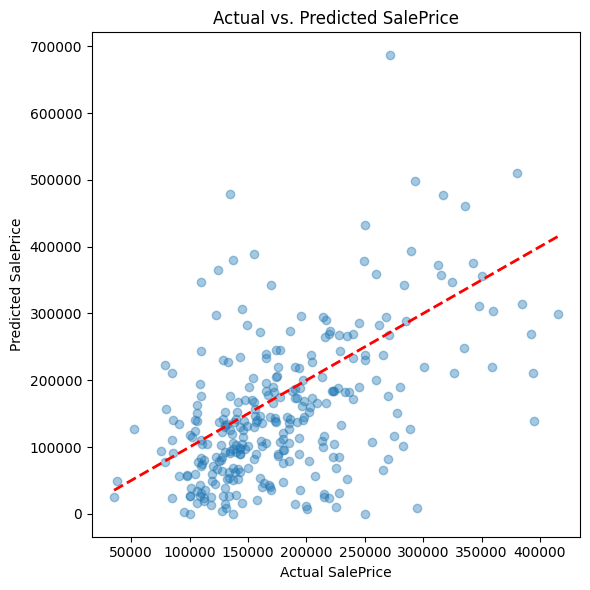

In [19]:
# Ensure model is in evaluation mode
model.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    for xb, yb_log in val_loader:
        xb = xb.to(device)
        # yb_log is already on device
        log_preds = model(xb).cpu().numpy().flatten()
        true_log  = yb_log.cpu().numpy().flatten()

        # Invert the log1p transform
        all_preds.extend(np.expm1(log_preds))
        all_targets.extend(np.expm1(true_log))

# Convert lists to arrays
all_preds   = np.array(all_preds)
all_targets = np.array(all_targets)

# Compute metrics
rmse_real = np.sqrt(mean_squared_error(all_targets, all_preds))
r2_real   = r2_score(all_targets, all_preds)

print("Validation Performance (Real Price Scale):")
print(f"  RMSE: {rmse_real:.2f}")
print(f"  R² : {r2_real:.4f}")

# Scatter plot of Actual vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.4)
min_val, max_val = all_targets.min(), all_targets.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs. Predicted SalePrice")
plt.tight_layout()
plt.show()

## 6. Evaluation

### 6.1 Evaluate Training Performance

In [20]:
# Make sure we're not tracking gradients
model.eval()
with torch.no_grad():
    # Predict log‐prices
    log_preds = model(X_train_tensor).cpu().numpy().flatten()
    # Invert log1p to get actual prices
    preds_price = np.expm1(log_preds)
    true_price  = np.expm1(y_train_tensor.cpu().numpy().flatten())

# Compute real‐scale metrics
rmse_train = np.sqrt(mean_squared_error(true_price, preds_price))
r2_train   = r2_score(true_price, preds_price)

print("Training Performance (Full Set, Real-Scale):")
print(f"  RMSE: {rmse_train:.2f}")
print(f"  R² : {r2_train:.4f}")

Training Performance (Full Set, Real-Scale):
  RMSE: 67456.17
  R² : 0.2785


### 6.2 Learning Curves

### 6.3 Error Analysis

,Id,Actual,Predicted,Error,Pct_Error
932,933,320000.125000,958784.125000,638784.00000,199.619919
961,962,272000.062500,686662.062500,414662.00000,152.449219
482,483,155000.046875,522496.843750,367496.81250,237.094635
1313,1314,333167.937500,700253.375000,367085.43750,110.180305
653,654,135000.062500,479096.062500,344096.00000,254.885818
691,692,755000.000000,428280.500000,326719.50000,43.274105
304,305,295000.062500,9343.532227,285656.53125,96.832703
919,920,176499.921875,445682.031250,269182.12500,152.511185
1152,1153,229999.906250,494688.125000,264688.21875,115.081879
1346,1347,262500.000000,521707.625000,259207.62500,98.745766


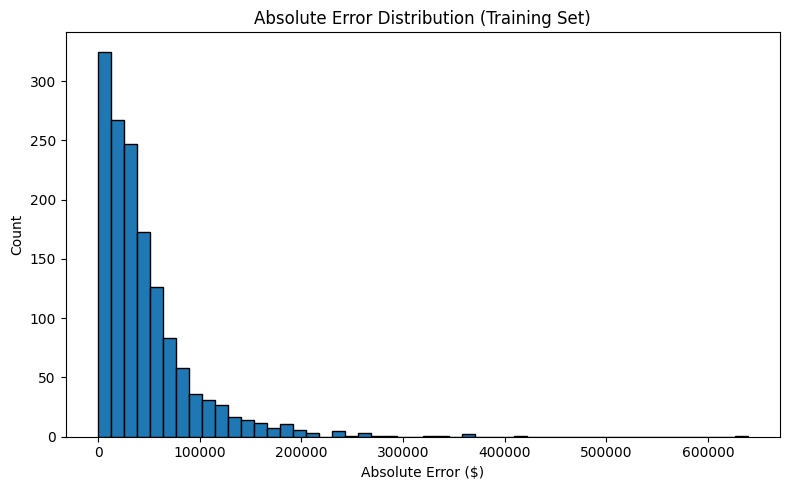

In [22]:
model.eval()
with torch.no_grad():
    log_preds = model(X_train_tensor).cpu().numpy().flatten()
    preds     = np.expm1(log_preds)
    actual    = np.expm1(y_train_tensor.cpu().numpy().flatten())

# Compute absolute and percent errors
errors       = np.abs(preds - actual)
percent_errs = errors / actual * 100

# Build a DataFrame for the worst offenders
error_df = pd.DataFrame({
    "Id":        df_train["Id"],
    "Actual":    actual,
    "Predicted": preds,
    "Error":     errors,
    "Pct_Error": percent_errs
})

top10 = error_df.sort_values("Error", ascending=False).head(10)
display(top10)

# Plot distribution of errors
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, edgecolor='k')
plt.title("Absolute Error Distribution (Training Set)")
plt.xlabel("Absolute Error ($)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### 6.4 Cross-Validation

In [23]:
k_folds       = 5
cv_epochs     = 100
cv_batch_size = 64
cv_scores     = []

kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    print(f"\n→ Fold {fold+1}/{k_folds}")

    # Slice NumPy arrays, then convert to tensors
    X_tr = torch.tensor(X_train_scaled[train_idx], dtype=torch.float32).to(device)
    y_tr = torch.tensor(y_train_array[train_idx],  dtype=torch.float32).to(device)
    X_va = torch.tensor(X_train_scaled[val_idx],   dtype=torch.float32).to(device)
    y_va = torch.tensor(y_train_array[val_idx],    dtype=torch.float32).to(device)

    # DataLoader
    tr_ds = TensorDataset(X_tr, y_tr)
    tr_loader = DataLoader(tr_ds, batch_size=cv_batch_size, shuffle=True)

    # Fresh model for this fold
    fold_model = HousingPriceModel(input_size).to(device)
    fold_opt   = torch.optim.AdamW(fold_model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Train briefly
    for epoch in range(cv_epochs):
        fold_model.train()
        for xb, yb in tr_loader:
            fold_opt.zero_grad()
            loss = nn.MSELoss()(fold_model(xb), yb)
            loss.backward()
            fold_opt.step()

    # Validate
    fold_model.eval()
    with torch.no_grad():
        val_log_preds = fold_model(X_va).cpu().numpy().flatten()
        val_log_true  = y_va.cpu().numpy().flatten()
    # Compute log-RMSE
    fold_rmse = np.sqrt(mean_squared_error(val_log_true, val_log_preds))
    cv_scores.append(fold_rmse)
    print(f"Fold {fold+1} log-RMSE: {fold_rmse:.5f}")

print(f"\nCV log-RMSE: {np.mean(cv_scores):.5f} ± {np.std(cv_scores):.5f}")


→ Fold 1/5
Fold 1 log-RMSE: 1.25256

→ Fold 2/5
Fold 2 log-RMSE: 1.76220

→ Fold 3/5
Fold 3 log-RMSE: 1.97353

→ Fold 4/5
Fold 4 log-RMSE: 1.70261

→ Fold 5/5
Fold 5 log-RMSE: 1.32092

CV log-RMSE: 1.60236 ± 0.27384


### 6.5 Estimate Kaggle Score (Log RMSE)

In [24]:
model.eval()
all_log_preds, all_log_true = [], []

with torch.no_grad():
    for xb, yb_log in val_loader:
        xb, yb_log = xb.to(device), yb_log.to(device)
        # Predict log‐prices
        preds_log = model(xb).cpu().numpy().flatten()
        # Collect predictions and true log‐values
        all_log_preds.extend(preds_log)
        all_log_true.extend(yb_log.cpu().numpy().flatten())

# Convert to NumPy arrays
all_log_preds = np.array(all_log_preds)
all_log_true  = np.array(all_log_true)

# Compute log‐RMSE
kaggle_score = np.sqrt(mean_squared_error(all_log_true, all_log_preds))
print(f"Estimated Kaggle Score (Log RMSE): {kaggle_score:.5f}")

Estimated Kaggle Score (Log RMSE): 1.20300


## 7. Final Predictions and Submission

In [25]:
# Ensure model is in evaluation mode
model.eval()

# Use no_grad to avoid tracking gradients during inference
with torch.no_grad():
    # Get predictions on the test set
    test_predictions = model(X_test_tensor.to(device)).cpu().numpy()

# Prepare submission DataFrame
# Load original test file to get Ids
submission1 = pd.read_csv(data_test_path)

# Insert predicted values
submission1['SalePrice'] = test_predictions.flatten()

# Save to CSV
submission1[['Id', 'SalePrice']].to_csv('submission3.csv', index=False)

print("Submission file saved as 'submission3.csv'")


Submission file saved as 'submission3.csv'
